In [1]:
using Pkg
Pkg.add("HTTP")
Pkg.add("JSON")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("StatsBase")
Pkg.add("StatsModels")
Pkg.add("GLM")

    Updating registry at `C:\Users\bowus\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\bowus\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No

In [ ]:
using HTTP
using JSON
using DataFrames

api_key = "QYZ7VDE3GOZ47FWZ"
symbol = "AAPL"

function get_price_alpha_vantage(symbol, start_date, end_date)
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=$(symbol)&apikey=$(api_key)"
    response = HTTP.get(url)
    data = JSON.parse(String(response.body))
    
    # Extract the time series data
    time_series = data["Time Series (Daily)"]
    
    # Convert to DataFrame
    df = DataFrame(Date=Date[], Open=Float64[], High=Float64[], Low=Float64[], Close=Float64[], Volume=Int64[])
    for (date, values) in time_series
        if Date(date) >= Date(start_date) && Date(date) <= Date(end_date)
            push!(df, (Date(date), parse(Float64, values["1. open"]), parse(Float64, values["2. high"]),
                        parse(Float64, values["3. low"]), parse(Float64, values["4. close"]),
                        parse(Int64, values["5. volume"])))
        end
    end
    
    # Sort by date
    sort!(df, :Date, rev=true)
    return df
end

# Fetch data for AAPL from Jan 2023 to Aug 2024
data = get_price_alpha_vantage("AAPL", "2023-01-01", "2024-08-31")
println(data)


In [3]:
using CSV
using DataFrames

# Specify the file path of the dataset
file_path = "C:/Users/bowus/OneDrive - Emory/PhD Economics/Year 2/Time Series/Homework/Assignment 1/AAPL.csv"


# Read the dataset into a DataFrame
data = CSV.read(file_path, DataFrame)

# Display the DataFrame
display(df)

Row,Date,Open,High,Low,Close,Adj Close,Volume
,Date,Float64,Float64,Float64,Float64,Float64,Int64
1,2021-01-04,133.52,133.61,126.76,129.41,128.087,143301900
2,2021-01-05,128.89,131.74,128.43,131.01,129.671,97664900
3,2021-01-06,127.72,131.05,126.38,126.6,125.306,155088000
4,2021-01-07,128.36,131.63,127.86,130.92,129.582,109578200
5,2021-01-08,132.43,132.63,130.23,132.05,130.7,105158200
6,2021-01-11,129.19,130.17,128.5,128.98,127.661,100384500
7,2021-01-12,128.5,129.69,126.86,128.8,127.483,91951100
8,2021-01-13,128.76,131.45,128.49,130.89,129.552,88636800
9,2021-01-14,130.8,131.0,128.76,128.91,127.592,90221800


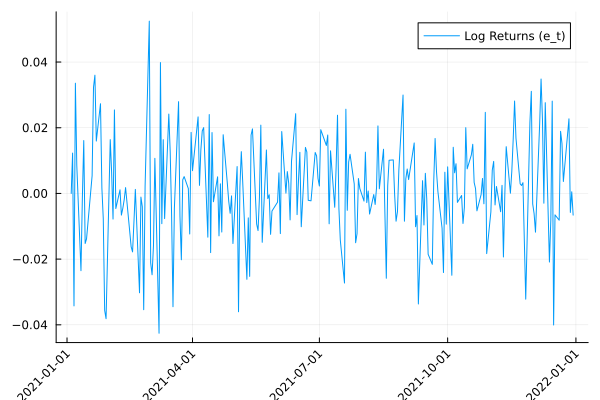

In [6]:
# Calculate the log difference
log_prices = log.(data.Close)
log_diff = [0.0; diff(log_prices)]

# Assign the log difference series to a new variable e_t
e_t = log_diff

# Plot the return series
using Plots
plot(data.Date, e_t, label="Log Returns (e_t)", xrotation=45, fmt=:png)
#savefig("Returns.png")  # Save with 1920x1080 resolution


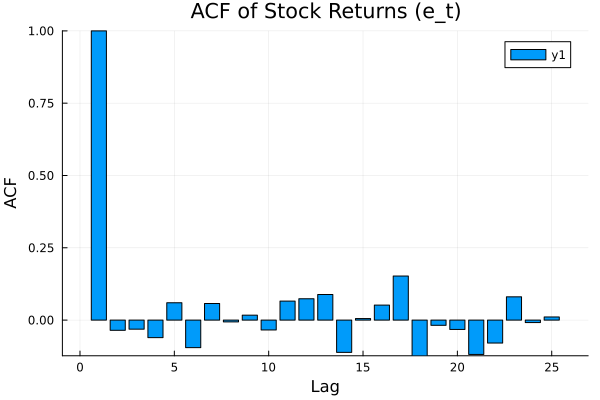

In [9]:
using StatsBase

# Compute the ACF of e_t
acf_values = autocor(e_t)

# Plot ACF
plot(acf_values, seriestype=:bar, title="ACF of Stock Returns (e_t)", xlabel="Lag", ylabel="ACF")

#savefig("ACF_plot.png")  # Save with 1920x1080 resolution


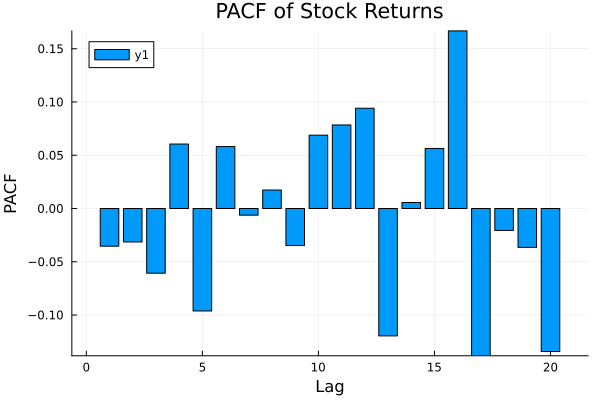

In [12]:
using StatsModels
using GLM
using DataFrames
using ShiftedArrays # for creating lagged variables 
# Calculate PACF using a different approach, e.g., by fitting AR models:
function pacf(data, max_lag)
    pacf_values = zeros(max_lag)
    for k in 1:max_lag
        df = DataFrame(data = data)
        df.lag_data = lag(data, k)
        model = lm(@formula(data ~ lag_data), df)
        pacf_values[k] = coef(model)[2]
    end
    return pacf_values
end

# Specify the maximum number of lags for PACF
max_lag = 20
pacf_values = pacf(e_t, max_lag)
# Plot PACF
plot(pacf_values, seriestype=:bar, title="PACF of Stock Returns", xlabel="Lag", ylabel="PACF")
#savefig("PACF_plot.png")  # Save with 1920x1080 resolution


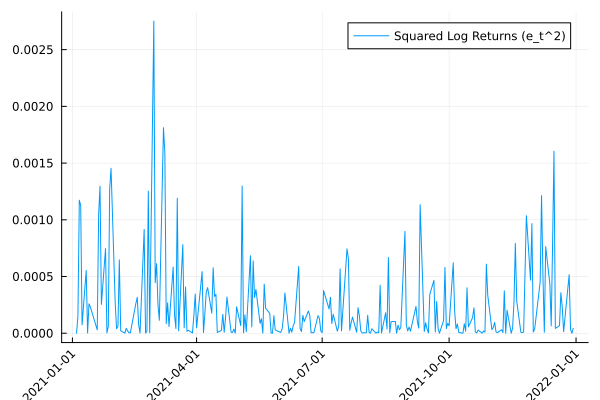

In [14]:
# Plot e_t^2 

plot(data.Date, e_t.^2, label="Squared Log Returns (e_t^2)", xrotation=45, fmt=:png)
#savefig("Returns_squared.png")  # Save with 1920x1080 resolution

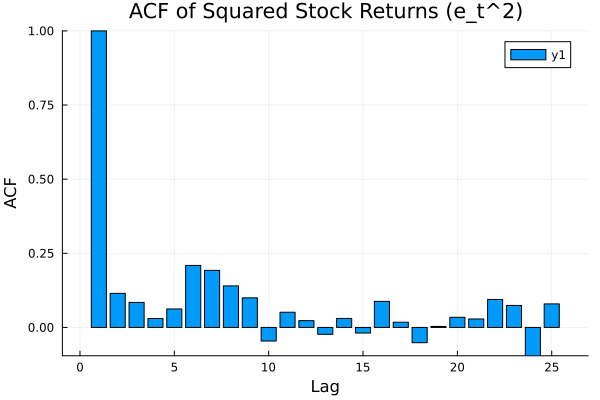

In [16]:
#Compute the ACF of e_t^2
using StatsBase
e_t2 = e_t.^2
acf_values_sq = autocor(e_t2)

# Plot ACF
plot(acf_values_sq, seriestype=:bar, title="ACF of Squared Stock Returns (e_t^2)", xlabel="Lag", ylabel="ACF")
#savefig("ACF_sqaured_plot.png")  # Save with 1920x1080 resolution



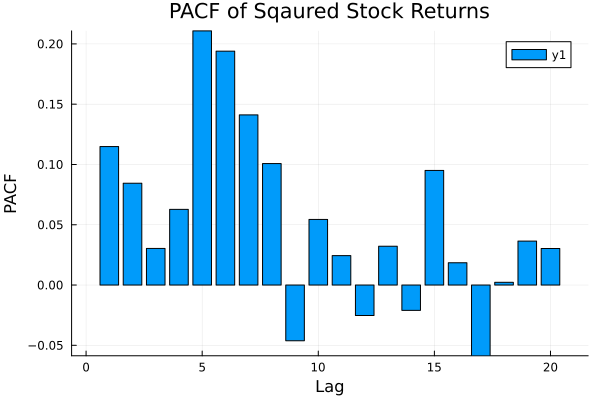

In [18]:
# plot the PACF of e_t^2
max_lag = 20
pacf_values_sq = pacf(e_t2, max_lag)
# Plot PACF
plot(pacf_values_sq, seriestype=:bar, title="PACF of Sqaured Stock Returns", xlabel="Lag", ylabel="PACF")
#savefig("PACF_sqaured_plot.png")  # Save with 1920x1080 resolution
